In [1]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#Get the stock quote 
# df = web.DataReader('^NSEI', data_source='yahoo', start='2012-01-01', end='2021-06-29') 
df = pd.read_csv("Dataset/NIFTY 50.csv")
# droping null values
df = df.dropna()
#Show the data 
df

,Date,Open,High,Low,Close,Volume,Turnover,P/E,P/B,Div Yield
0,2000-01-03,1482.15,1592.90,1482.15,1592.20,25358322,8.841500e+09,25.91,4.63,0.95
1,2000-01-04,1594.40,1641.95,1594.40,1638.70,38787872,1.973690e+10,26.67,4.76,0.92
2,2000-01-05,1634.55,1635.50,1555.05,1595.80,62153431,3.084790e+10,25.97,4.64,0.95
3,2000-01-06,1595.80,1639.00,1595.80,1617.60,51272875,2.531180e+10,26.32,4.70,0.94
4,2000-01-07,1616.60,1628.25,1597.20,1613.30,54315945,1.914630e+10,26.25,4.69,0.94
...,...,...,...,...,...,...,...,...,...,...
5203,2020-11-27,13012.05,13035.30,12914.30,12968.95,1162360673,7.852293e+11,35.66,3.67,1.22
5204,2020-12-01,13062.20,13128.40,12962.80,13109.05,583633902,3.291726e+11,36.05,3.71,1.21
5205,2020-12-02,13121.40,13128.50,12983.55,13113.75,717711761,3.400874e+11,36.06,3.71,1.21
5206,2020-12-03,13215.30,13216.60,13107.90,13133.90,713688035,3.962771e+11,36.12,3.72,1.21


In [3]:
df.shape

(5208, 10)

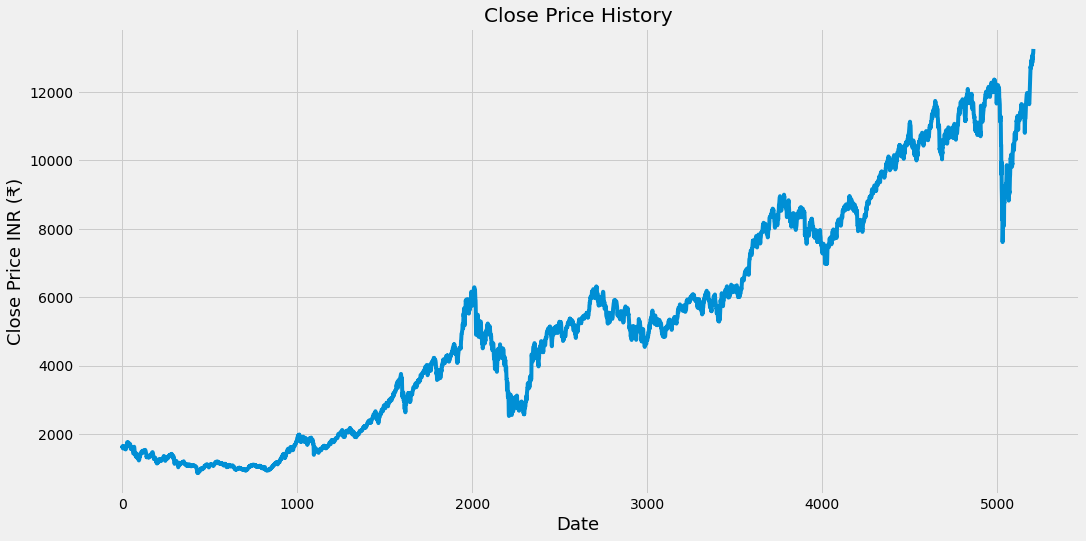

In [4]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
#plt.plot(x = df['Date'] , y = df['Close'])
plt.plot(df.index, df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price INR (₹)',fontsize=18)
plt.show()

In [5]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [6]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [7]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [8]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [10]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [11]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
4107/4107 [==============================] - 73s 14ms/step - loss: 7.6908e-04
Epoch 2/5
4107/4107 [==============================] - 56s 14ms/step - loss: 1.6293e-04
Epoch 3/5
4107/4107 [==============================] - 57s 14ms/step - loss: 1.0743e-04
Epoch 4/5
4107/4107 [==============================] - 57s 14ms/step - loss: 8.6567e-05
Epoch 5/5
4107/4107 [==============================] - 58s 14ms/step - loss: 8.1513e-05


In [13]:
#Save the model
model.save("NSE_Prediction_model", save_format='h5')

In [14]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [15]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [16]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [17]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [18]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

157.20624903364276

<ipython-input-19-432d364b5d11>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


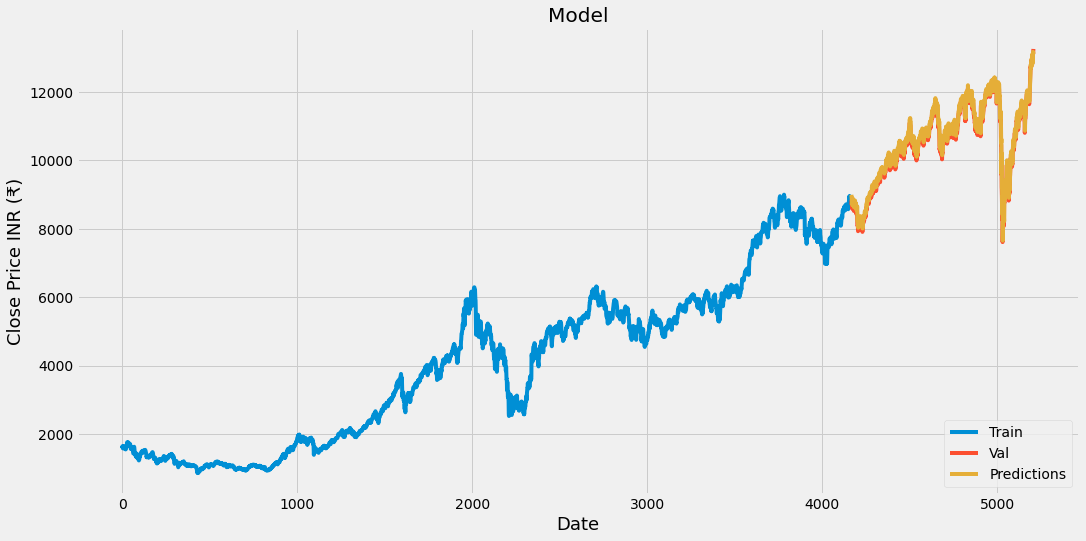

In [19]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price INR (₹)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.savefig('NSE_Predicted_Graph.png')
plt.show()

In [20]:
#Show the valid and predicted prices
valid

,Close,Predictions
4167,8831.55,8992.329102
4168,8723.05,8940.283203
4169,8706.40,8829.464844
4170,8745.15,8823.412109
4171,8591.25,8865.391602
...,...,...
5203,12968.95,13065.726562
5204,13109.05,12969.545898
5205,13113.75,13173.764648
5206,13133.90,13115.978516
